# 1. Building basic QNN example
## 1.a Construct a 2-qubit basic quantum  neural network
> 2011.00027 논문을 참고하거나, 자유롭게 FeatureMap과 Ansatz 사용

In [42]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

def FeatureMapBuilder(num_features, reps):
    feature_map = ZZFeatureMap(
        feature_dimension=num_features,
        reps=reps,
    )
    return feature_map

def AnsatzBuilder(num_qubits, reps):
    ansatz = TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks='ry',
        entanglement_blocks='cx',
        entanglement='full', 
        reps=reps, 
        insert_barriers=True
    )
    return ansatz

from qiskit_machine_learning.circuit.library import QNNCircuit

def QnnModelCircuitBuilder(num_qubits, reps_feature_map, reps_ansatz):
    feature_map = FeatureMapBuilder(num_qubits, reps_feature_map)
    ansatz = AnsatzBuilder(num_qubits, reps_ansatz)

    qnn_circuit = QNNCircuit(
        num_qubits=num_qubits,
        feature_map=feature_map,
        ansatz=ansatz
    )
    return qnn_circuit

- ZZFeatureMap 기반 FeatureMap 생성 함수
- TwoLocal 회로 기반 Ansatz 생성 함수
- QNN circuit 생성 함수


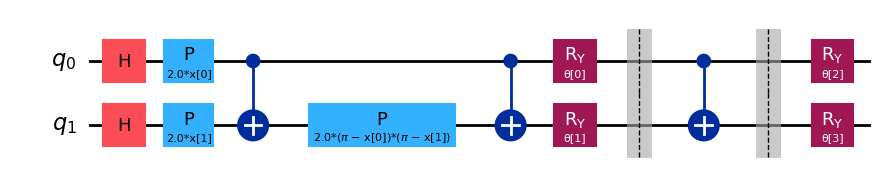

In [43]:
qnn_circuit = QnnModelCircuitBuilder(
    num_qubits=2,
    reps_feature_map=1,
    reps_ansatz=1
)

qnn_circuit.decompose().draw("mpl")

## 1.b. Compute Effective Dimension of the Model
> Training data의 Distribution에 대한 dependence를 찾기
- by varying the input data

In [44]:
from qiskit.primitives import StatevectorSampler as Sampler
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN

In [45]:
sampler = Sampler()
#Sampler 기반 QNN인 samplerQNN 정의
qnn = SamplerQNN(
    circuit=qnn_circuit,
    input_params=qnn_circuit.feature_map.parameters,
    weight_params=qnn_circuit.ansatz.parameters,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [46]:
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
def plot_effective_dimension(input_samples,weight_samples):
    global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

    d = qnn.num_weights
    
    print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
    print(
        "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
    )

    global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
    print("Effective dimension: {}".format(global_eff_dim_1))

    print("Number of weights: {}".format(d))
    plt.plot(n, np.array(global_eff_dim_1) / d)
    plt.xlabel("Number of data")
    plt.ylabel("Normalized GLOBAL effective dimension")
    plt.show()

In [47]:
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

print(input_samples)
# from sklearn.preprocessing import MinMaxScaler
# tmp_input_samples = MinMaxScaler().fit_transform(input_samples)
# print(tmp_input_samples)

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)



[[ 1.12039065  0.71280137]
 [ 1.1864461  -0.80029423]
 [ 0.42522686 -1.3777356 ]
 [-0.56583771  0.46158659]
 [ 0.44153942 -0.88880634]
 [ 1.00226096  0.42374051]
 [ 1.35154575 -0.24179673]
 [ 0.76007399 -1.38259203]
 [-0.17332659  0.38337151]
 [ 0.48154813  0.60434032]]


Data size: 5000, global effective dimension: 3.9868
Number of weights: 4, normalized effective dimension: 0.9967
Effective dimension: [3.98831321 3.98623072 3.98573077 3.98581062 3.98626414 3.98689907
 3.98741421 3.98777446 3.98885344 3.98958313]
Number of weights: 4


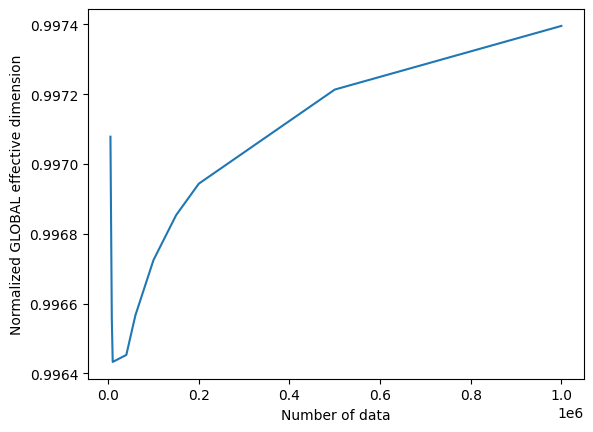

In [48]:
plot_effective_dimension(
    input_samples=input_samples,
    weight_samples=weight_samples
)